In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [170]:
# Units in inches
heightOffGround = 8
rInner = 5
lenRod = 18.5
rOuter = lenRod - rInner
rCenter = lenRod/2
numMotors = 4
numFeet = numMotors*2
motorAngle = 360/float(numFeet)
angleBetween = 360/float(numFeet)
rCurveFeet = 4
# Encoder steps per inch
motorScale = 4990  # encoder steps per inch
minLiftAngle = 25  # 15 to 20 according to Anthony
maxMotorSpeed = 1  # inch per second

In [126]:
def rotate(points, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    rotMat = np.array(((c, -s), (s, c))).T
    return np.dot(points, rotMat)
def translate(points, offset):
    return points + offset
def append(*pointArrs):
    total = None
    for points in pointArrs:
        if points is None:
            continue
        points = np.array(points)
        if len(points.shape) < 2:
            points = np.array([points])
        if total is None:
            total = points
        else:
            total = np.concatenate((total, points), axis=0)
    return total
def appendWithGaps(*pointArrs):
    total = None
    gap = [np.NaN, np.NaN]
    for points in pointArrs:
        if points is None:
            pass
        elif total is None:
            total = points
        else:
            total = append(total, gap, points)
    return total

In [127]:
def foot():
    n = 8
    points = [[0, rCurveFeet]]
    for i in xrange(1,n+1):
        p = rotate(points[0], np.pi*2/numFeet/n*i)
        points.append(p)
    points = rotate(np.array(points), -np.pi/numFeet)
    points = translate(points, [0, -rCurveFeet])
    return points
footPoints = foot()
def footAtAngleDistance(ang, dist):
    return rotate(translate(footPoints, [0, dist]), ang)
def footPair(spacing):
    f1 = footAtAngleDistance(0, spacing/2)
    f2 = footAtAngleDistance(np.pi, spacing/2)
    rod = [[0, spacing/2], [0, -spacing/2]]
    return appendWithGaps(rod, f1, f2)
footPairPoints = footPair(lenRod)
def footPairAtAngleOffset(ang, offset):
    return rotate(translate(footPairPoints, [0, offset]), ang)

In [148]:
def calcPositionPoints(angle, motors):
    assert len(motors) == numMotors, "Wrong number of motors"
    points = None
    for i in xrange(numMotors):
        a = np.deg2rad(angle+i*motorAngle)
        offset = motors[i]/float(motorScale)
        r1 = rCenter + offset
        r2 = rCenter - offset
        assert rInner <= r1 <= rOuter and rInner <= r2 <= rOuter, "Motor out of bounds"
        points = appendWithGaps(points, footPairAtAngleOffset(a, offset))
    return points

In [204]:
def drawPosition(angle, motors, xpos=0, zeroMarker=True):
    points = calcPositionPoints(angle, motors)
    if xpos != 0:
        points = translate(points, [xpos, 0])
    
    if zeroMarker:
        marker = translate(rotate([[0, 0], [0, 15]], np.deg2rad(angle)),
                           [xpos, 0])
        plt.plot(marker.T[0], marker.T[1], 'g:')
    
    plt.plot(points.T[0], points.T[1], 'b-')
    
    a = rOuter*1.1
    plt.plot([-10**10, 10**10], [-heightOffGround, -heightOffGround], 'r:')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim([-a,a])
    plt.ylim([-a,a])

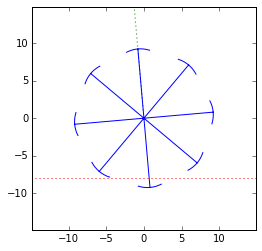

In [205]:
drawPosition(5, [0,0,0,0])

In [181]:
def domainAndOffset(angle):
    domain = int(((360-angle+angleBetween/2.0)/(angleBetween)) % numFeet)
    offset = (angle+domain*angleBetween-360) % 360
    #domain = ((360-angle+angleBetween/2.0)/(angleBetween)) % numFeet
    return (domain,offset)

In [182]:
# Actual trig calculations here
def calcPositionsFromOffset(offset):
    h = heightOffGround
    t_0 = np.deg2rad(offset)
    t_1 = np.deg2rad(offset+45)
    t_nm1 = np.deg2rad(offset-45)
    x_0 = rCurveFeet*(1-np.cos(t_0))
    x_1 = rCurveFeet*(1-np.cos(t_1))
    x_nm1 = rCurveFeet*(1-np.cos(t_nm1))
    a_0 = (h-x_0)/np.cos(t_0)
    a_1 = (h-x_1)/np.cos(t_1)
    a_nm1 = (h-x_nm1)/np.cos(t_nm1)
    motors = [0]*numMotors
    motors[0] = (rCenter-a_0)
    motors[1] = (rCenter-a_1)
    motors[-1] = (a_nm1-rCenter)
    for i in xrange(len(motors)):
        if motors[i] > rOuter-rCenter:
            motors[i] = rOuter-rCenter
        if motors[i] < -(rOuter-rCenter):
            motors[i] = -(rOuter-rCenter)
        motors[i] = motors[i] * motorScale
    return motors

In [183]:
def calcPositions(angle):
    domain, offset = domainAndOffset(angle)
    motorsDomain = calcPositionsFromOffset(offset)
    motors = [0]*len(motorsDomain)
    for i, md in zip(xrange(len(motorsDomain)), motorsDomain):
        motors[(i+domain)%numMotors] = md if (i+domain)%numFeet < numMotors else -md
    return np.array(motors)

In [211]:
def constrainSpeed(lastMotorPos, commandMotorPos, timeInterval):
    if lastMotorPos is None:
        return commandMotorPos
    maxChange = maxMotorSpeed*motorScale*float(timeInterval)
    diff = commandMotorPos - lastMotorPos
    diff[diff>maxChange] = maxChange
    diff[diff<-maxChange] = -maxChange
    return lastMotorPos + diff

array([ 6161.25604263, -4854.74758413,     0.        ,  -141.57050493])

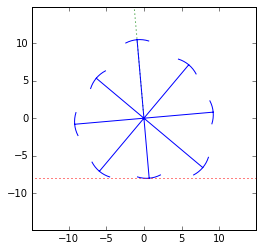

In [212]:
angle = 5
drawPosition(angle, calcPositions(angle))
calcPositions(angle)

KeyboardInterrupt: 

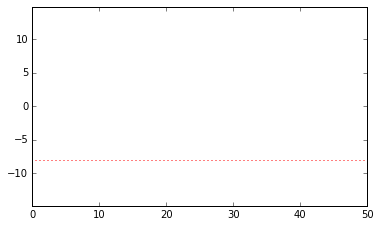

In [213]:
actualPos = None
degreeStep = 5
timeInterval = degreeStep/6.0
xStart = 0
for angle in xrange(0,720,degreeStep):
    plt.clf()
    commandPos = calcPositions(-angle)
    actualPos = constrainSpeed(actualPos, commandPos, timeInterval)
    xpos = heightOffGround*(angle*np.pi/180)
    drawPosition(-angle, actualPos, xpos=xStart+xpos)
    display.clear_output(wait=True)
    plt.xlim([0,50])
    #plt.ylim([-a,a])
    display.display(plt.gcf())